Feature Importances and Weights:
                    Feature  Importance    Weight
11   Layer 8 Deviation (mm)   30.244391  0.302444
10   Layer 7 Deviation (mm)   14.527579  0.145276
4    Layer 1 Deviation (mm)   11.493831  0.114938
12   Layer 9 Deviation (mm)    8.253465  0.082535
1           Angle_dev (deg)    8.153380  0.081534
13  Layer 10 Deviation (mm)    5.993223  0.059932
3           layer_height_cv    4.321755  0.043218
7    Layer 4 Deviation (mm)    4.034932  0.040349
6    Layer 3 Deviation (mm)    3.929033  0.039290
2             Max Span (mm)    3.427875  0.034279
8    Layer 5 Deviation (mm)    1.869425  0.018694
0    total_height_deviation    1.744469  0.017445
5    Layer 2 Deviation (mm)    1.343732  0.013437
9    Layer 6 Deviation (mm)    0.662908  0.006629


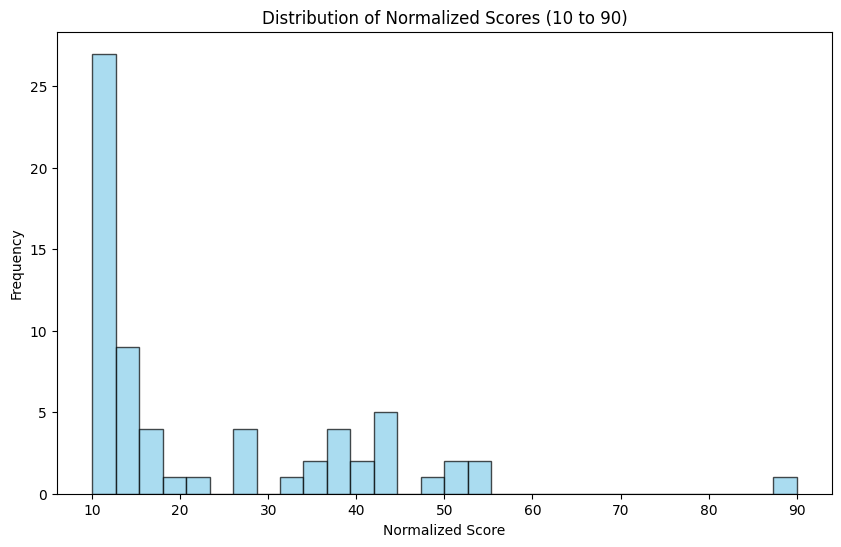

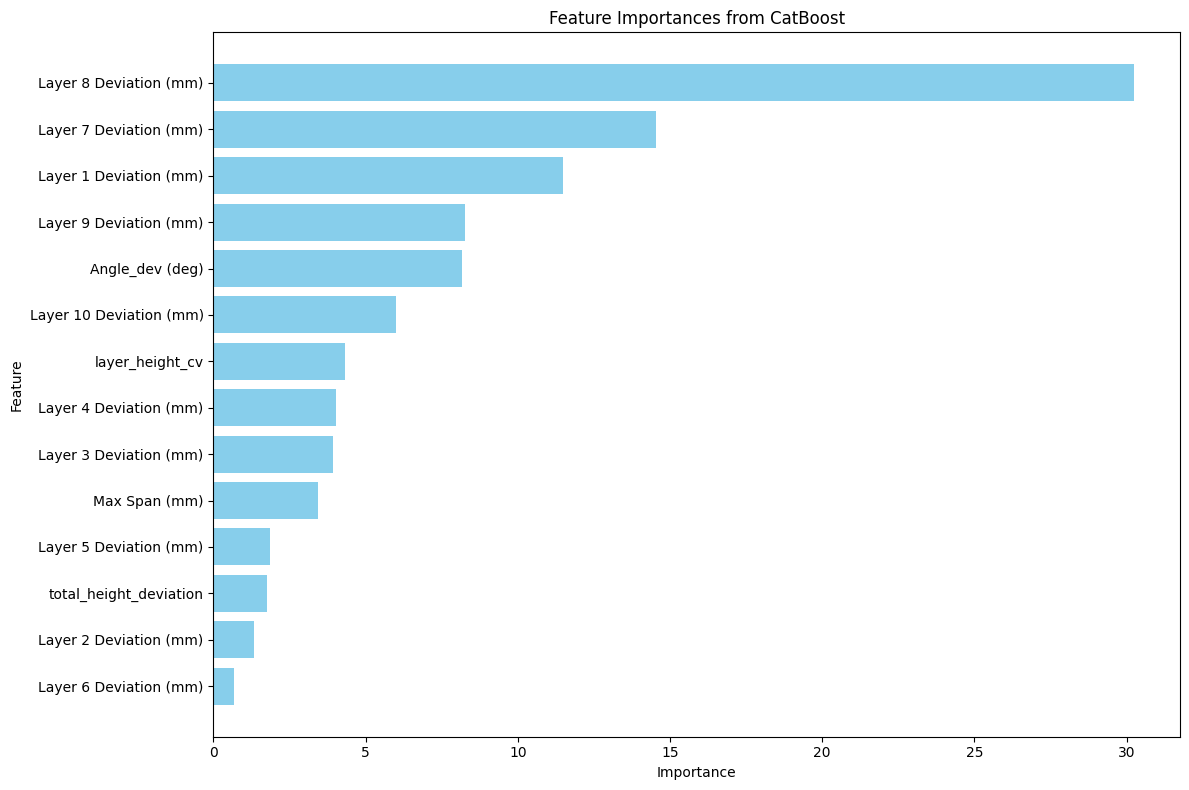

   Combined_Metric  Normalized_Score  Print_Quality
0        11.874745         41.275692     Good Print
1        10.789962         23.178655  Average Print
2        12.552177         52.577053     Good Print
3        12.642043         54.076255     Good Print
4        11.841605         40.722844     Good Print


'classified_print_quality_fixed.csv'

In [2]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'data_with_metrics.csv'
data = pd.read_csv(file_path)

# Replace "Fail" with NaN and handle missing values
data.replace("Fail", np.nan, inplace=True)

# Dynamically determine the relevant layer deviation features
layer_columns = [col for col in data.columns if "Layer" in col and "Deviation" in col]

# Select only geometric features for the metric
geometric_features = [
    'total_height_deviation', 'Angle_dev (deg)', 'Max Span (mm)', 'layer_height_cv'
] + layer_columns

# Ensure all geometric features are numeric
for feature in geometric_features:
    data[feature] = pd.to_numeric(data[feature], errors='coerce')

# Filter rows to ensure all geometric features and the target are numeric and non-missing
valid_rows = data[geometric_features + ['layer_var']].dropna()

# Separate features and target
X = valid_rows[geometric_features]
y = valid_rows['layer_var']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the CatBoost model
model = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, random_seed=42, verbose=0)
model.fit(X_train, y_train, eval_set=(X_test, y_test))

# Get feature importances
feature_importances = model.get_feature_importance(Pool(X_train, label=y_train))
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Normalize feature importances to sum to 1 (weights for the combined metric)
feature_importance_df['Weight'] = feature_importance_df['Importance'] / feature_importance_df['Importance'].sum()

# Display feature importances and weights
print("Feature Importances and Weights:")
print(feature_importance_df)

# Create the combined metric
def calculate_combined_metric(row, features, weights):
    combined_metric = 10  # Base offset to ensure non-negativity
    for i in range(len(features)):
        feature = features[i]
        weight = weights[i]
        value = row[feature]

        if 'Deviation' in feature or 'height_cv' in feature:  # Lower is better
            combined_metric += value * weight
        elif 'Span' in feature:  # Higher is better
            if value > 0:  # Only include if valid
                combined_metric -= value * weight  # Subtract contribution for "higher is better"
        elif 'Angle' in feature:  # Optional: Lower is better
            if value > 0:  # Only include if valid
                combined_metric += value * weight

    return max(10, combined_metric)  # Ensure Combined Metric is not negative

# Apply the combined metric to the dataset
weights = feature_importance_df['Weight'].values
valid_rows['Combined_Metric'] = valid_rows.apply(lambda row: calculate_combined_metric(row, geometric_features, weights), axis=1)

# Normalize the combined metric using a robust scale
def robust_normalize(metric, min_value, max_value):
    return (metric - min_value) / (max_value - min_value) * 80 + 10  # Scale between 10 and 90

min_metric = valid_rows['Combined_Metric'].min()
max_metric = valid_rows['Combined_Metric'].max()

valid_rows['Normalized_Score'] = valid_rows['Combined_Metric'].apply(lambda x: robust_normalize(x, min_metric, max_metric))

# Plot the distribution of the normalized scores
plt.figure(figsize=(10, 6))
plt.hist(valid_rows['Normalized_Score'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Normalized Scores (10 to 90)')
plt.xlabel('Normalized Score')
plt.ylabel('Frequency')
plt.show()

# Visualize feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from CatBoost')
plt.gca().invert_yaxis()  # Flip the y-axis for better visualization
plt.tight_layout()
plt.show()

# Assign thresholds based on the normalized scores
good_threshold = valid_rows['Normalized_Score'].quantile(0.75)  # Top 25% is "Good"
bad_threshold = valid_rows['Normalized_Score'].quantile(0.25)   # Bottom 25% is "Bad"

# Classify prints
def classify_print(score, good_threshold, bad_threshold):
    if score >= good_threshold:
        return "Good Print"
    elif score <= bad_threshold:
        return "Bad Print"
    else:
        return "Average Print"

valid_rows['Print_Quality'] = valid_rows['Normalized_Score'].apply(lambda x: classify_print(x, good_threshold, bad_threshold))

# Save the dataset with the new classification
output_path = 'classified_print_quality_fixed.csv'
valid_rows.to_csv(output_path, index=False)

# Display sample data
print(valid_rows[['Combined_Metric', 'Normalized_Score', 'Print_Quality']].head())

# Output path for user
output_path


Feature Importances and Weights:
                    Feature  Importance    Weight
12  Layer 10 Deviation (mm)   22.545894  0.225459
9    Layer 7 Deviation (mm)   16.564733  0.165647
8    Layer 6 Deviation (mm)   12.920703  0.129207
13          layer_height_cv   11.675413  0.116754
3    Layer 1 Deviation (mm)    7.039017  0.070390
4    Layer 2 Deviation (mm)    5.543115  0.055431
10   Layer 8 Deviation (mm)    4.798158  0.047982
11   Layer 9 Deviation (mm)    4.335548  0.043355
6    Layer 4 Deviation (mm)    3.802307  0.038023
0    total_height_deviation    3.275904  0.032759
1           Angle_dev (deg)    2.013464  0.020135
7    Layer 5 Deviation (mm)    1.910862  0.019109
5    Layer 3 Deviation (mm)    1.860207  0.018602
2             Max Span (mm)    1.714675  0.017147


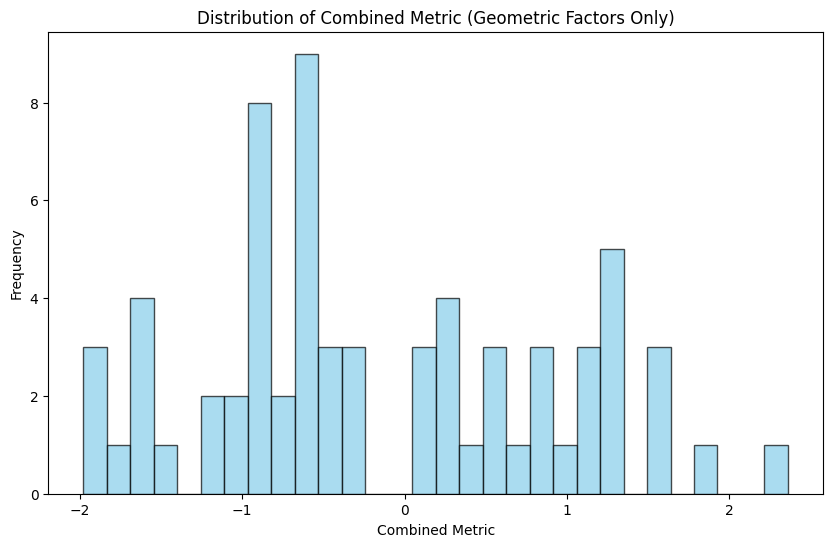

   Combined_Metric  Print_Quality
0         0.183141  Average Print
1        -0.335573  Average Print
2         0.490389  Average Print
3         0.563516  Average Print
4         0.210811  Average Print


'classified_print_quality_geometric_fixed.csv'

In [6]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'data_with_metrics.csv'
data = pd.read_csv(file_path)

# Replace "Fail" with NaN and handle missing values
data.replace("Fail", np.nan, inplace=True)

# Impute missing values (e.g., with median for simplicity)
data.fillna(data.median(numeric_only=True), inplace=True)

# Select only geometric features for the metric (excluding layer_var)
geometric_features = [
    'total_height_deviation', 'Angle_dev (deg)', 'Max Span (mm)',
    'Layer 1 Deviation (mm)', 'Layer 2 Deviation (mm)', 'Layer 3 Deviation (mm)',
    'Layer 4 Deviation (mm)', 'Layer 5 Deviation (mm)', 'Layer 6 Deviation (mm)',
    'Layer 7 Deviation (mm)', 'Layer 8 Deviation (mm)', 'Layer 9 Deviation (mm)',
    'Layer 10 Deviation (mm)', 'layer_height_cv'
]

# Filter rows to ensure all geometric features and the target are numeric and non-missing
valid_rows = data[geometric_features + ['layer_var']].dropna()

# Separate features and target
X = valid_rows[geometric_features]
y = valid_rows['layer_var']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the CatBoost model
model = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, random_seed=42, verbose=0)
model.fit(X_train, y_train, eval_set=(X_test, y_test))

# Get feature importances
feature_importances = model.get_feature_importance(Pool(X_train, label=y_train))
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Normalize feature importances to sum to 1 (weights for the combined metric)
feature_importance_df['Weight'] = feature_importance_df['Importance'] / feature_importance_df['Importance'].sum()

# Display feature importances and weights
print("Feature Importances and Weights:")
print(feature_importance_df)

# Create the combined metric
def calculate_combined_metric(row, features, weights):
    combined_metric = 0
    for i in range(len(features)):
        if 'Deviation' in features[i] or 'height_cv' in features[i]:  # Lower is better
            combined_metric += row[features[i]] * weights[i]
        elif 'Span' in features[i]:  # Higher is better
            combined_metric -= row[features[i]] * weights[i]  # Subtract to penalize lower spans
    return combined_metric

# Apply the combined metric to the dataset
weights = feature_importance_df['Weight'].values
valid_rows['Combined_Metric'] = valid_rows.apply(lambda row: calculate_combined_metric(row, geometric_features, weights), axis=1)

# Plot the distribution of the combined metric to determine thresholds
plt.figure(figsize=(10, 6))
plt.hist(valid_rows['Combined_Metric'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Combined Metric (Geometric Factors Only)')
plt.xlabel('Combined Metric')
plt.ylabel('Frequency')
plt.show()

# Assign thresholds based on the distribution
good_threshold = valid_rows['Combined_Metric'].quantile(0.25)  # Bottom 25% is "Good"
bad_threshold = valid_rows['Combined_Metric'].quantile(0.75)   # Top 25% is "Bad"

# Classify prints
def classify_print(metric, good_threshold, bad_threshold):
    if metric <= good_threshold:
        return "Good Print"
    elif metric >= bad_threshold:
        return "Bad Print"
    else:
        return "Average Print"

valid_rows['Print_Quality'] = valid_rows['Combined_Metric'].apply(lambda x: classify_print(x, good_threshold, bad_threshold))

# Save the dataset with the new classification
output_path = 'classified_print_quality_geometric_fixed.csv'
valid_rows.to_csv(output_path, index=False)

# Display sample data
print(valid_rows[['Combined_Metric', 'Print_Quality']].head())

# Output path for user
output_path


Feature Importances and Weights:
                    Feature  Importance    Weight
12   Layer 8 Deviation (mm)   21.829859  0.218299
14  Layer 10 Deviation (mm)   18.393984  0.183940
2                 layer_var   14.997710  0.149977
11   Layer 7 Deviation (mm)    9.994836  0.099948
13   Layer 9 Deviation (mm)    8.795134  0.087951
0              Speed (mm/s)    5.617553  0.056176
15          layer_height_cv    4.190875  0.041909
3    total_height_deviation    3.323326  0.033233
6    Layer 2 Deviation (mm)    3.065035  0.030650
10   Layer 6 Deviation (mm)    2.914480  0.029145
5    Layer 1 Deviation (mm)    1.764217  0.017642
4          deposition_ratio    1.666362  0.016664
8    Layer 4 Deviation (mm)    1.477529  0.014775
9    Layer 5 Deviation (mm)    1.135556  0.011356
7    Layer 3 Deviation (mm)    0.611699  0.006117
1             Flowrate (Hz)    0.221847  0.002218


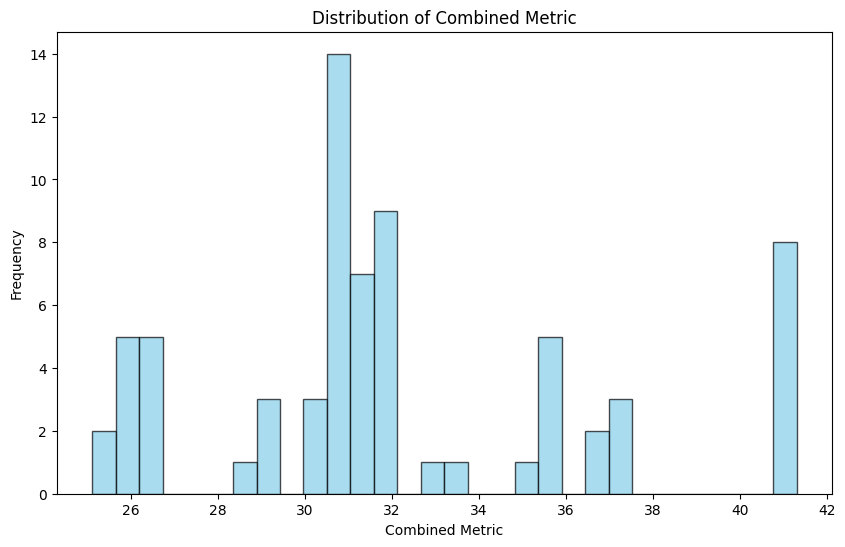

   Combined_Metric Print_Quality
0        26.057081    Good Print
1        25.573154    Good Print
2        26.343210    Good Print
3        26.601537    Good Print
4        26.116721    Good Print


In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'data_with_metrics.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Select features for the metric and the target
features = [
    'Speed (mm/s)', 'Flowrate (Hz)', 'layer_var', 'total_height_deviation',
    'deposition_ratio', 'Layer 1 Deviation (mm)', 'Layer 2 Deviation (mm)',
    'Layer 3 Deviation (mm)', 'Layer 4 Deviation (mm)', 'Layer 5 Deviation (mm)',
    'Layer 6 Deviation (mm)', 'Layer 7 Deviation (mm)', 'Layer 8 Deviation (mm)',
    'Layer 9 Deviation (mm)', 'Layer 10 Deviation (mm)', 'layer_height_cv'
]
X = data[features]
y = data['layer_var']  # Using `layer_var` as the target (deviation minimization)

# Ensure no non-numeric values in X
X = X.apply(pd.to_numeric, errors='coerce').dropna()

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the CatBoost model
model = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, random_seed=42, verbose=0)
model.fit(X_train, y_train, eval_set=(X_test, y_test))

# Get feature importances
feature_importances = model.get_feature_importance(Pool(X_train, label=y_train))
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Normalize feature importances to sum to 1 (weights for the combined metric)
feature_importance_df['Weight'] = feature_importance_df['Importance'] / feature_importance_df['Importance'].sum()

# Display feature importances and weights
print("Feature Importances and Weights:")
print(feature_importance_df)

# Create the combined metric
def calculate_combined_metric(row, features, weights):
    return np.sum([row[features[i]] * weights[i] for i in range(len(features))])

# Apply the combined metric to the dataset
weights = feature_importance_df['Weight'].values
data['Combined_Metric'] = data.apply(lambda row: calculate_combined_metric(row, features, weights), axis=1)

# Plot the distribution of the combined metric to determine thresholds
plt.figure(figsize=(10, 6))
plt.hist(data['Combined_Metric'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Combined Metric')
plt.xlabel('Combined Metric')
plt.ylabel('Frequency')
plt.show()

# Assign thresholds based on the distribution (adjust as necessary)
good_threshold = data['Combined_Metric'].quantile(0.25)  # Example: bottom 25% is "Good"
bad_threshold = data['Combined_Metric'].quantile(0.75)   # Example: top 25% is "Bad"

# Classify prints
def classify_print(metric, good_threshold, bad_threshold):
    if metric <= good_threshold:
        return "Good Print"
    elif metric >= bad_threshold:
        return "Bad Print"
    else:
        return "Average Print"

data['Print_Quality'] = data['Combined_Metric'].apply(lambda x: classify_print(x, good_threshold, bad_threshold))

# Save the dataset with the new classification
data.to_csv('classified_print_quality.csv', index=False)

# Display sample data
print(data[['Combined_Metric', 'Print_Quality']].head())


Feature Importances and Weights:
                    Feature  Importance    Weight
12   Layer 8 Deviation (mm)   21.829859  0.218299
14  Layer 10 Deviation (mm)   18.393984  0.183940
2                 layer_var   14.997710  0.149977
11   Layer 7 Deviation (mm)    9.994836  0.099948
13   Layer 9 Deviation (mm)    8.795134  0.087951
0              Speed (mm/s)    5.617553  0.056176
15          layer_height_cv    4.190875  0.041909
3    total_height_deviation    3.323326  0.033233
6    Layer 2 Deviation (mm)    3.065035  0.030650
10   Layer 6 Deviation (mm)    2.914480  0.029145
5    Layer 1 Deviation (mm)    1.764217  0.017642
4          deposition_ratio    1.666362  0.016664
8    Layer 4 Deviation (mm)    1.477529  0.014775
9    Layer 5 Deviation (mm)    1.135556  0.011356
7    Layer 3 Deviation (mm)    0.611699  0.006117
1             Flowrate (Hz)    0.221847  0.002218


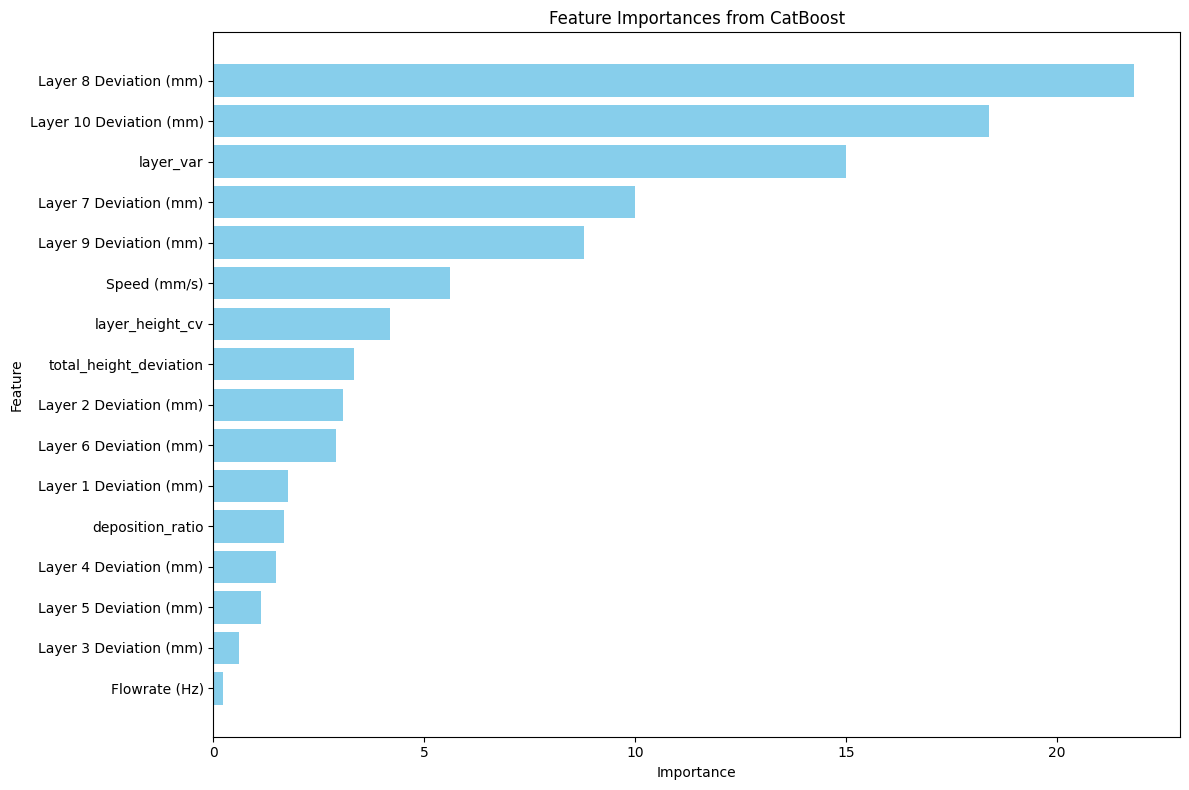

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'data_with_metrics.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Select features for the metric and the target
features = [
    'Speed (mm/s)', 'Flowrate (Hz)', 'layer_var', 'total_height_deviation',
    'deposition_ratio', 'Layer 1 Deviation (mm)', 'Layer 2 Deviation (mm)',
    'Layer 3 Deviation (mm)', 'Layer 4 Deviation (mm)', 'Layer 5 Deviation (mm)',
    'Layer 6 Deviation (mm)', 'Layer 7 Deviation (mm)', 'Layer 8 Deviation (mm)',
    'Layer 9 Deviation (mm)', 'Layer 10 Deviation (mm)', 'layer_height_cv'
]
X = data[features]
y = data['layer_var']  # Using `layer_var` as the target (deviation minimization)

# Ensure no non-numeric values in X
X = X.apply(pd.to_numeric, errors='coerce').dropna()

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the CatBoost model
model = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, random_seed=42, verbose=0)
model.fit(X_train, y_train, eval_set=(X_test, y_test))

# Get feature importances
feature_importances = model.get_feature_importance(Pool(X_train, label=y_train))
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Normalize feature importances to sum to 1 (weights for the combined metric)
feature_importance_df['Weight'] = feature_importance_df['Importance'] / feature_importance_df['Importance'].sum()

# Display feature importances and weights
print("Feature Importances and Weights:")
print(feature_importance_df)

# Visualize feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from CatBoost')
plt.gca().invert_yaxis()  # Flip the y-axis for better visualization
plt.tight_layout()
plt.show()


In [10]:
# Calculate value ranges for Good, Average, and Bad prints
good_range = (data[data['Print_Quality'] == 'Good Print']['Combined_Metric'].min(),
              data[data['Print_Quality'] == 'Good Print']['Combined_Metric'].max())

average_range = (data[data['Print_Quality'] == 'Average Print']['Combined_Metric'].min(),
                 data[data['Print_Quality'] == 'Average Print']['Combined_Metric'].max())

bad_range = (data[data['Print_Quality'] == 'Bad Print']['Combined_Metric'].min(),
             data[data['Print_Quality'] == 'Bad Print']['Combined_Metric'].max())

# Print the ranges
print("Value Ranges for Combined Metric:")
print(f"Good Prints: {good_range}")
print(f"Average Prints: {average_range}")
print(f"Bad Prints: {bad_range}")

# Save ranges to a dictionary for further use
ranges = {
    "Good Prints": good_range,
    "Average Prints": average_range,
    "Bad Prints": bad_range
}


Value Ranges for Combined Metric:
Good Prints: (25.115595975267908, 30.41491049734513)
Average Prints: (30.50572298982298, 35.35156867612573)
Bad Prints: (35.386782434255586, 41.30858196332612)


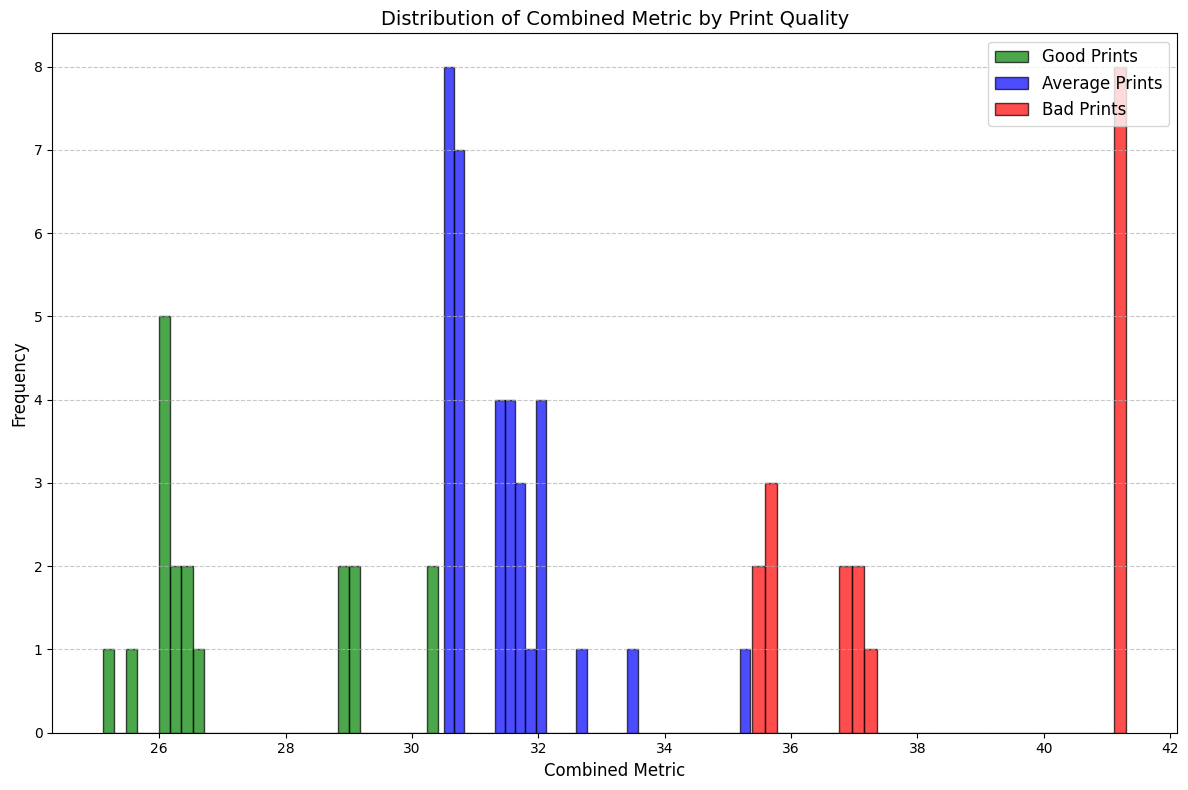

In [8]:
# Plot the distribution of Good, Average, and Bad prints
plt.figure(figsize=(12, 8))

# Filter data by print quality
good_prints = data[data['Print_Quality'] == 'Good Print']['Combined_Metric']
average_prints = data[data['Print_Quality'] == 'Average Print']['Combined_Metric']
bad_prints = data[data['Print_Quality'] == 'Bad Print']['Combined_Metric']

# Plot histograms for each category
plt.hist(good_prints, bins=30, alpha=0.7, label='Good Prints', color='green', edgecolor='black')
plt.hist(average_prints, bins=30, alpha=0.7, label='Average Prints', color='blue', edgecolor='black')
plt.hist(bad_prints, bins=30, alpha=0.7, label='Bad Prints', color='red', edgecolor='black')

# Add labels, title, and legend
plt.title('Distribution of Combined Metric by Print Quality', fontsize=14)
plt.xlabel('Combined Metric', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(loc='upper right', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


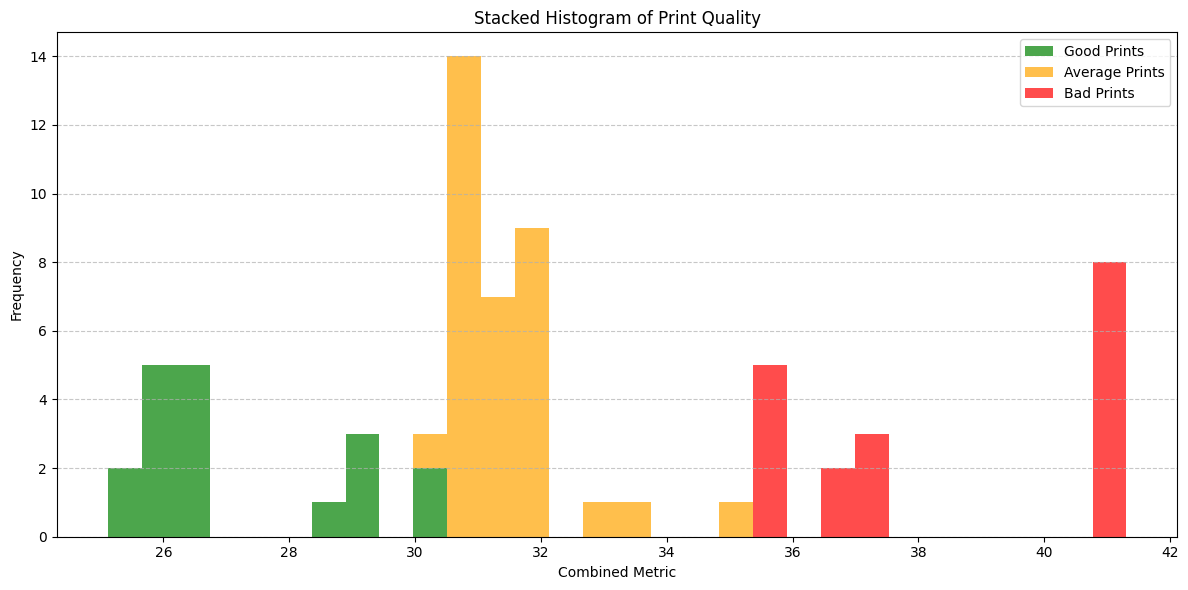

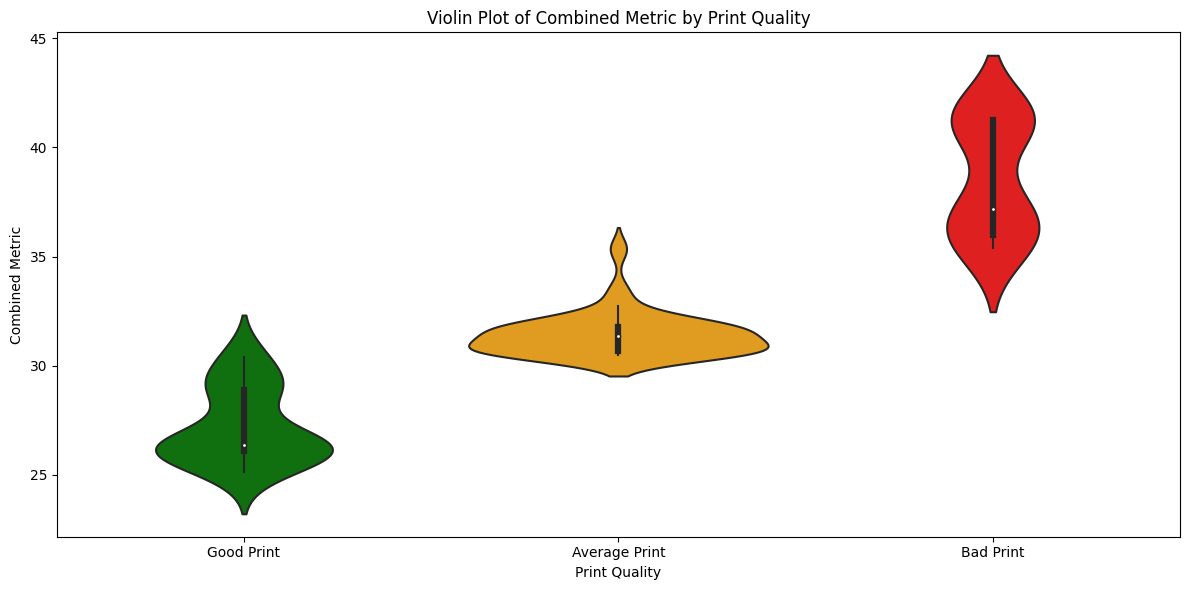

C:\Users\Ahmad\AppData\Local\Temp\ipykernel_16956\1846515170.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(good_prints, shade=True, color='green', label='Good Prints', alpha=0.7)
C:\Users\Ahmad\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Ahmad\AppData\Local\Temp\ipykernel_16956\1846515170.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(average_prints, shade=True, color='orange', label='Average Prints', alpha=0.7)
C:\Users\Ahmad\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is

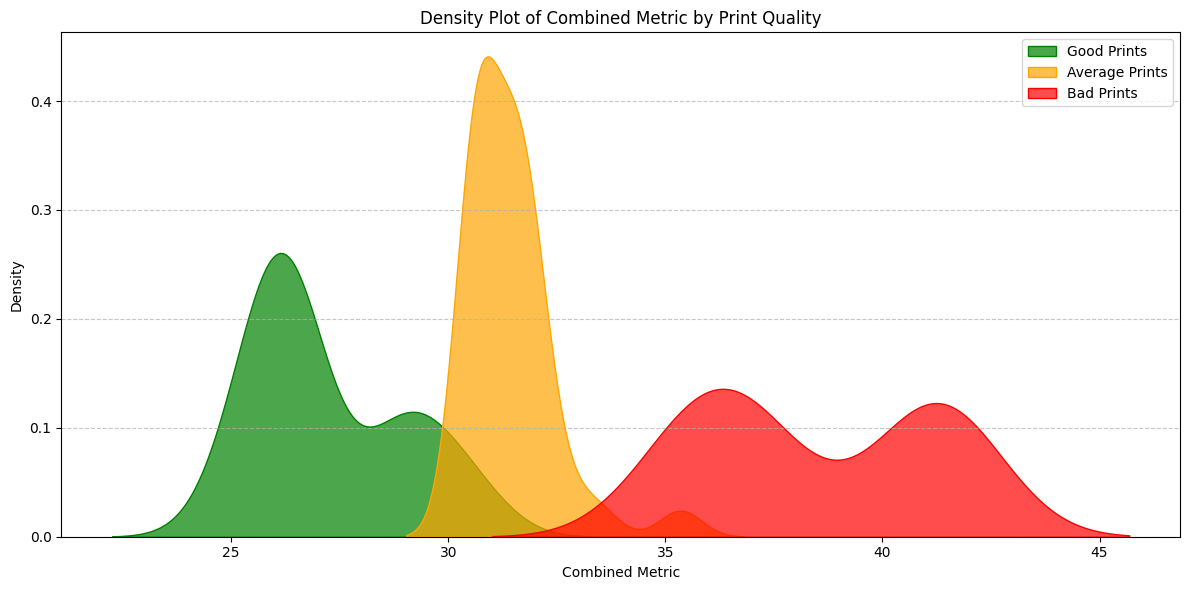

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data subsets
good_prints = data[data['Print_Quality'] == 'Good Print']['Combined_Metric']
average_prints = data[data['Print_Quality'] == 'Average Print']['Combined_Metric']
bad_prints = data[data['Print_Quality'] == 'Bad Print']['Combined_Metric']

# 1. Stacked Histogram
plt.figure(figsize=(12, 6))
plt.hist([good_prints, average_prints, bad_prints], bins=30, stacked=True, 
         color=['green', 'orange', 'red'], label=['Good Prints', 'Average Prints', 'Bad Prints'], alpha=0.7)
plt.title('Stacked Histogram of Print Quality')
plt.xlabel('Combined Metric')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 2. Violin Plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='Print_Quality', y='Combined_Metric', data=data, palette={'Good Print': 'green', 'Average Print': 'orange', 'Bad Print': 'red'})
plt.title('Violin Plot of Combined Metric by Print Quality')
plt.xlabel('Print Quality')
plt.ylabel('Combined Metric')
plt.tight_layout()
plt.show()

# 3. Density Plot with Shading
plt.figure(figsize=(12, 6))
sns.kdeplot(good_prints, shade=True, color='green', label='Good Prints', alpha=0.7)
sns.kdeplot(average_prints, shade=True, color='orange', label='Average Prints', alpha=0.7)
sns.kdeplot(bad_prints, shade=True, color='red', label='Bad Prints', alpha=0.7)
plt.title('Density Plot of Combined Metric by Print Quality')
plt.xlabel('Combined Metric')
plt.ylabel('Density')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


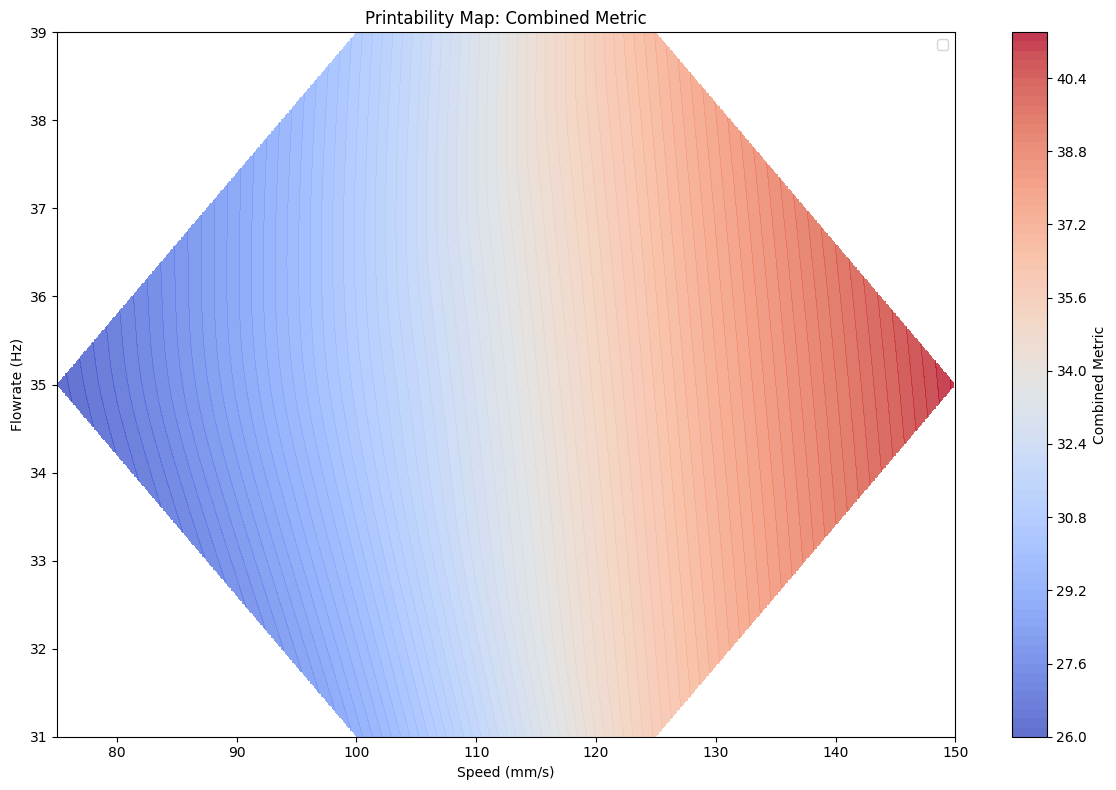

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import pandas as pd


data=pd.read_csv('classified_print_quality.csv')
# Prepare the data
x = data['Speed (mm/s)'].values
y = data['Flowrate (Hz)'].values
z = data['Combined_Metric'].values

# Create a grid for Speed and Flowrate
xi = np.linspace(x.min(), x.max(), 500)  # Increase resolution for smooth contours
yi = np.linspace(y.min(), y.max(), 500)
xi_grid, yi_grid = np.meshgrid(xi, yi)

# Interpolate Combined_Metric onto the grid
zi = griddata((x, y), z, (xi_grid, yi_grid), method='cubic')

# Plot the contour map
plt.figure(figsize=(12, 8))
contour = plt.contourf(xi_grid, yi_grid, zi, levels=100, cmap='coolwarm', alpha=0.8)
colorbar = plt.colorbar(label='Combined Metric')
#plt.scatter(x, y, c='black', s=5, label='Data Points')  # Overlay original data points
plt.xlabel('Speed (mm/s)')
plt.ylabel('Flowrate (Hz)')
plt.title('Printability Map: Combined Metric')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


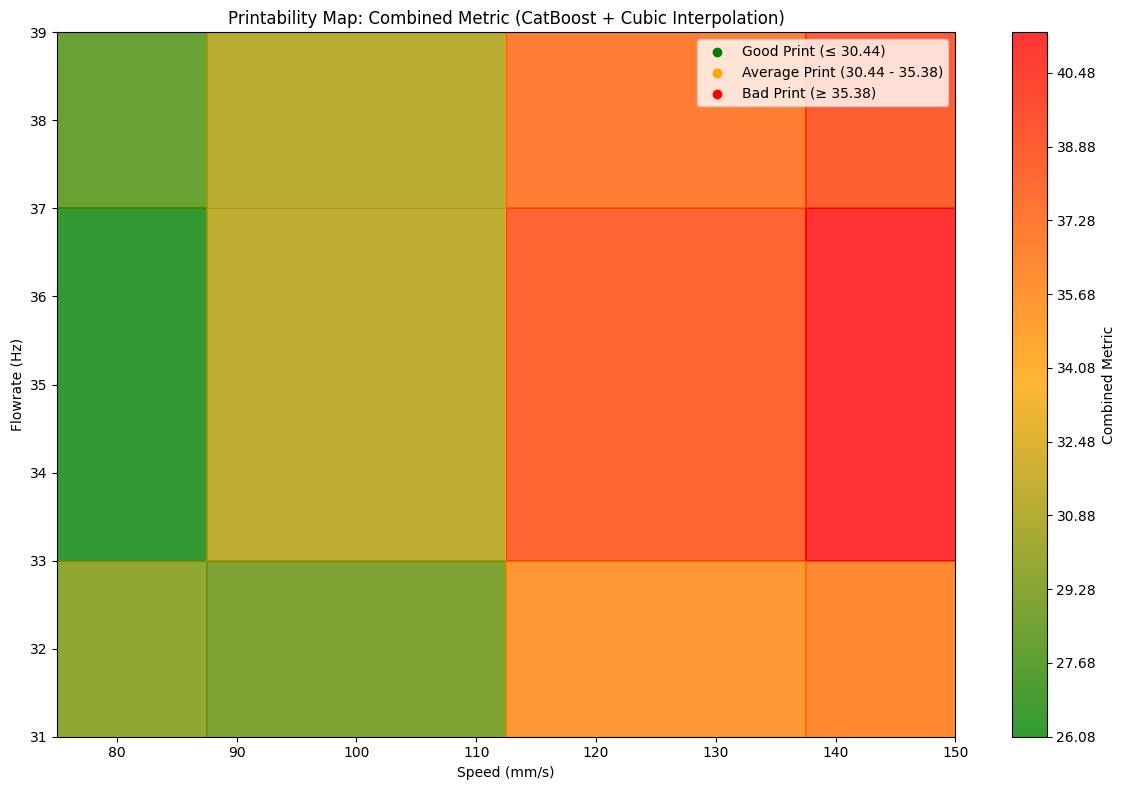

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from catboost import CatBoostRegressor

# Load the dataset
data = pd.read_csv('classified_print_quality.csv')

# Prepare the data
x = data['Speed (mm/s)'].values
y = data['Flowrate (Hz)'].values
z = data['Combined_Metric'].values

# Train a CatBoost model for predicting Combined Metric
features = ['Speed (mm/s)', 'Flowrate (Hz)']
X = data[features]
y_target = data['Combined_Metric']

# Train the CatBoost model
model = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, random_seed=42, verbose=0)
model.fit(X, y_target)

# Create a high-resolution grid for Speed and Flowrate
xi = np.linspace(x.min(), x.max(), 1000)  # Increase resolution
yi = np.linspace(y.min(), y.max(), 1000)
xi_grid, yi_grid = np.meshgrid(xi, yi)

# Flatten the grid for CatBoost predictions
grid_points = pd.DataFrame({
    'Speed (mm/s)': xi_grid.flatten(),
    'Flowrate (Hz)': yi_grid.flatten()
})

# Predict Combined Metric for the grid points using CatBoost
grid_points['Combined_Metric'] = model.predict(grid_points)

# Reshape predictions back into grid format
zi_predicted = grid_points['Combined_Metric'].values.reshape(xi_grid.shape)

# Use cubic interpolation for smoothing the predicted values
zi_interpolated = griddata(
    (grid_points['Speed (mm/s)'], grid_points['Flowrate (Hz)']),
    grid_points['Combined_Metric'],
    (xi_grid, yi_grid),
    method='cubic'
)

# Define thresholds for Good, Average, and Bad prints
good_threshold = np.percentile(z, 25)  # Bottom 25%
bad_threshold = np.percentile(z, 75)  # Top 25%

# Create a custom colormap to match legend colors
colors = [(0, "green"), (0.5, "orange"), (1, "red")]  # Define colors for Good, Average, Bad
custom_cmap = LinearSegmentedColormap.from_list("CustomMap", colors)

# Plot the filled contour map with cubic interpolation
plt.figure(figsize=(12, 8))
contour = plt.contourf(xi_grid, yi_grid, zi_interpolated, levels=200, cmap=custom_cmap, alpha=0.8)  # Use custom colormap
colorbar = plt.colorbar(label='Combined Metric')

# Add a legend for classifications
plt.scatter([], [], color='green', label=f"Good Print (≤ {good_threshold:.2f})")
plt.scatter([], [], color='orange', label=f"Average Print ({good_threshold:.2f} - {bad_threshold:.2f})")
plt.scatter([], [], color='red', label=f"Bad Print (≥ {bad_threshold:.2f})")

# Add labels and title
plt.xlabel('Speed (mm/s)')
plt.ylabel('Flowrate (Hz)')
plt.title('Printability Map: Combined Metric (CatBoost + Cubic Interpolation)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


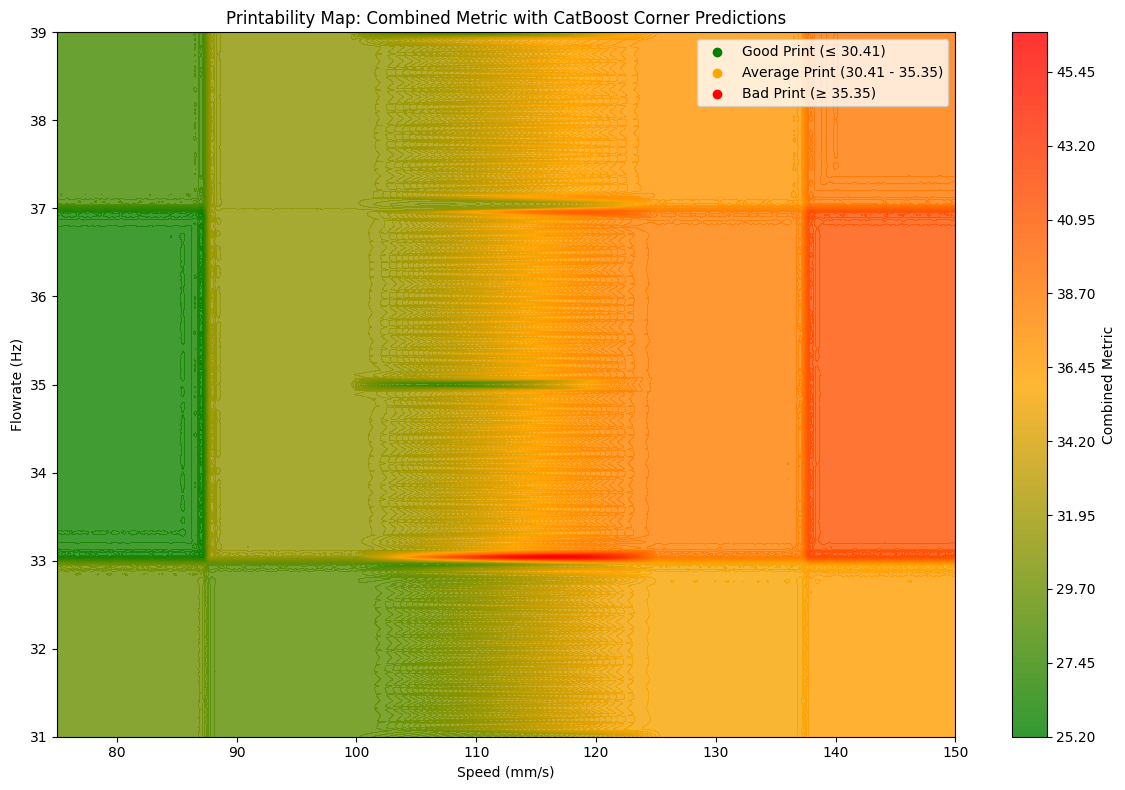

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import pandas as pd
from catboost import CatBoostRegressor
from matplotlib.colors import LinearSegmentedColormap

# Load the dataset
data = pd.read_csv('classified_print_quality.csv')

# Prepare the data
x = data['Speed (mm/s)'].values
y = data['Flowrate (Hz)'].values
z = data['Combined_Metric'].values

# Train a CatBoost model for predicting Combined Metric
features = ['Speed (mm/s)', 'Flowrate (Hz)']
X = data[features]
y_target = data['Combined_Metric']

# Train the CatBoost model
model = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, random_seed=42, verbose=0)
model.fit(X, y_target)

# Create corner regions for predictions
corner_regions = [
    # Top-left corner: Flowrate 35 to 39, Speed 75 to 100
    {'flowrate_range': (35, 39), 'speed_range': (75, 100)},
    # Top-right corner: Flowrate 35 to 39, Speed 125 to 150
    {'flowrate_range': (35, 39), 'speed_range': (125, 150)},
    # Bottom-left corner: Flowrate 31 to 35, Speed 75 to 100
    {'flowrate_range': (31, 35), 'speed_range': (75, 100)},
    # Bottom-right corner: Flowrate 31 to 35, Speed 125 to 150
    {'flowrate_range': (31, 35), 'speed_range': (125, 150)},
]

# Generate grid points for corners and predict Combined Metric
corner_points = []
for region in corner_regions:
    flowrates = np.linspace(region['flowrate_range'][0], region['flowrate_range'][1], 50)
    speeds = np.linspace(region['speed_range'][0], region['speed_range'][1], 50)
    grid = np.array(np.meshgrid(speeds, flowrates)).T.reshape(-1, 2)
    df = pd.DataFrame(grid, columns=['Speed (mm/s)', 'Flowrate (Hz)'])
    df['Combined_Metric'] = model.predict(df)  # Predict using CatBoost
    corner_points.append(df)

# Combine corner predictions with the original data
corner_data = pd.concat(corner_points)
combined_data = pd.concat([data[['Speed (mm/s)', 'Flowrate (Hz)', 'Combined_Metric']], corner_data])

# Create a high-resolution grid for the full map
xi = np.linspace(combined_data['Speed (mm/s)'].min(), combined_data['Speed (mm/s)'].max(), 1000)
yi = np.linspace(combined_data['Flowrate (Hz)'].min(), combined_data['Flowrate (Hz)'].max(), 1000)
xi_grid, yi_grid = np.meshgrid(xi, yi)

# Interpolate Combined Metric across the entire grid
zi_interpolated = griddata(
    (combined_data['Speed (mm/s)'], combined_data['Flowrate (Hz)']),
    combined_data['Combined_Metric'],
    (xi_grid, yi_grid),
    method='cubic'
)

# Define thresholds for Good, Average, and Bad prints
good_threshold = 30.41  # Example based on provided ranges
bad_threshold = 35.35

# Create a custom colormap to match the legend
colors = [(0, "green"), (0.5, "orange"), (1, "red")]
custom_cmap = LinearSegmentedColormap.from_list("CustomMap", colors)

# Plot the filled contour map
plt.figure(figsize=(12, 8))
contour = plt.contourf(xi_grid, yi_grid, zi_interpolated, levels=200, cmap=custom_cmap, alpha=0.8)
colorbar = plt.colorbar(label='Combined Metric')

# Add a legend for classifications
plt.scatter([], [], color='green', label=f"Good Print (≤ {good_threshold:.2f})")
plt.scatter([], [], color='orange', label=f"Average Print ({good_threshold:.2f} - {bad_threshold:.2f})")
plt.scatter([], [], color='red', label=f"Bad Print (≥ {bad_threshold:.2f})")

# Add labels and title
plt.xlabel('Speed (mm/s)')
plt.ylabel('Flowrate (Hz)')
plt.title('Printability Map: Combined Metric with CatBoost Corner Predictions')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


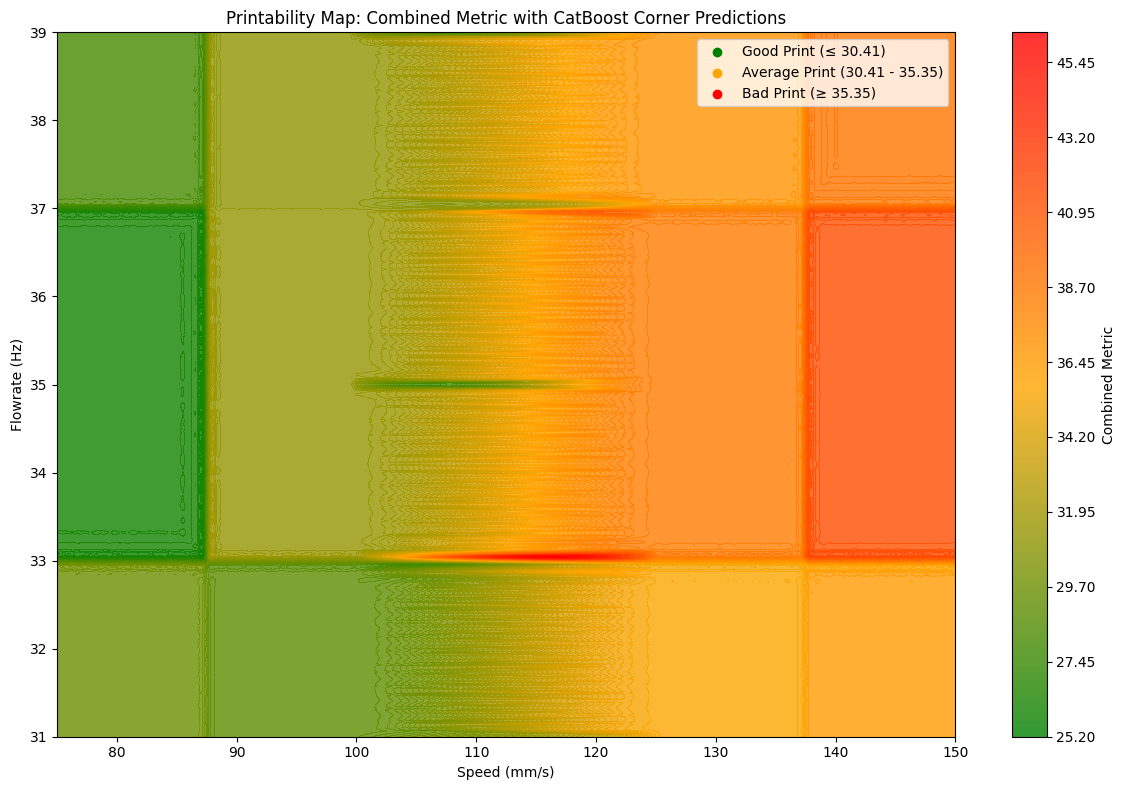

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import pandas as pd
from catboost import CatBoostRegressor
from matplotlib.colors import LinearSegmentedColormap

# Load the dataset
data = pd.read_csv('classified_print_quality.csv')

# Prepare the data
x = data['Speed (mm/s)'].values
y = data['Flowrate (Hz)'].values
z = data['Combined_Metric'].values

# Train a CatBoost model for predicting Combined Metric
features = ['Speed (mm/s)', 'Flowrate (Hz)']
X = data[features]
y_target = data['Combined_Metric']

# Train the CatBoost model
model = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, random_seed=42, verbose=0)
model.fit(X, y_target)

# Define corner regions for CatBoost predictions
corner_regions = [
    # Top-left corner: Flowrate 35 to 39, Speed 75 to 100
    {'flowrate_range': (35, 39), 'speed_range': (75, 100)},
    # Top-right corner: Flowrate 35 to 39, Speed 125 to 150
    {'flowrate_range': (35, 39), 'speed_range': (125, 150)},
    # Bottom-left corner: Flowrate 31 to 35, Speed 75 to 100
    {'flowrate_range': (31, 35), 'speed_range': (75, 100)},
    # Bottom-right corner: Flowrate 31 to 35, Speed 125 to 150
    {'flowrate_range': (31, 35), 'speed_range': (125, 150)},
]

# Generate grid points for corners and predict Combined Metric
corner_points = []
for region in corner_regions:
    flowrates = np.linspace(region['flowrate_range'][0], region['flowrate_range'][1], 50)
    speeds = np.linspace(region['speed_range'][0], region['speed_range'][1], 50)
    grid = np.array(np.meshgrid(speeds, flowrates)).T.reshape(-1, 2)
    df = pd.DataFrame(grid, columns=['Speed (mm/s)', 'Flowrate (Hz)'])
    df['Combined_Metric'] = model.predict(df)  # Predict using CatBoost
    corner_points.append(df)

# Combine corner predictions with the original data
corner_data = pd.concat(corner_points)
combined_data = pd.concat([data[['Speed (mm/s)', 'Flowrate (Hz)', 'Combined_Metric']], corner_data])

# Create a high-resolution grid for Speed and Flowrate
xi = np.linspace(combined_data['Speed (mm/s)'].min(), combined_data['Speed (mm/s)'].max(), 500)
yi = np.linspace(combined_data['Flowrate (Hz)'].min(), combined_data['Flowrate (Hz)'].max(), 500)
xi_grid, yi_grid = np.meshgrid(xi, yi)

# Interpolate Combined_Metric onto the grid
zi = griddata(
    (combined_data['Speed (mm/s)'], combined_data['Flowrate (Hz)']),
    combined_data['Combined_Metric'],
    (xi_grid, yi_grid),
    method='cubic'
)

# Define thresholds for Good, Average, and Bad prints
good_threshold = 30.41  # Example based on provided ranges
bad_threshold = 35.35

# Create a custom colormap to match classification
colors = [(0, "green"), (0.5, "orange"), (1, "red")]
custom_cmap = LinearSegmentedColormap.from_list("CustomMap", colors)

# Plot the contour map with the Combined Metric
plt.figure(figsize=(12, 8))
contour = plt.contourf(xi_grid, yi_grid, zi, levels=200, cmap=custom_cmap, alpha=0.8)
colorbar = plt.colorbar(label='Combined Metric')

# Add a legend for classifications
plt.scatter([], [], color='green', label=f"Good Print (≤ {good_threshold:.2f})")
plt.scatter([], [], color='orange', label=f"Average Print ({good_threshold:.2f} - {bad_threshold:.2f})")
plt.scatter([], [], color='red', label=f"Bad Print (≥ {bad_threshold:.2f})")

# Add labels and title
plt.xlabel('Speed (mm/s)')
plt.ylabel('Flowrate (Hz)')
plt.title('Printability Map: Combined Metric with CatBoost Corner Predictions')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
